In [1]:
import sys

sys.path.append('..')
from src.utils.factory import read_yaml
from src.dataset.dataset import MakeDataset
from src.models.networks import read_model
from src.ntk.generate import generate_ntk
from src.tools.train import train
from src.ntk.learning_curve import LearningCurve
from src.utils.visualize import visualize

/home/kwatanabe/miniconda3/envs/rnf/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read Setting

In [2]:
cfg = read_yaml(fpath='../src/config/config.yaml')

### Prepare dataset

In [3]:
database = MakeDataset(cfg)
# get data (numpy.array)
ar_X_tr, ar_X_te, ar_y_tr, ar_y_te = database.get_array()
# get data (torch.tensor)
te_X_tr, te_X_te, te_y_tr, te_y_te = database.get_tensor()

### Read model

In [4]:
net = read_model(cfg)

### Calculate optimal learning rate

In [5]:
lr = generate_ntk(net, 0, te_X_tr, te_X_te, cfg, calc_lr=True)

100%|██████████| 80/80 [00:00<00:00, 183.16it/s]


### Train model

In [6]:
f_train_0, f_test_0, results = train(cfg, net, lr, database)

Epoch[1/1000], TrainLoss: 0.1572, TestLoss: 0.1247, TestAcc: 0.2500
Epoch[2/1000], TrainLoss: 0.1566, TestLoss: 0.1242, TestAcc: 0.2500
Epoch[3/1000], TrainLoss: 0.1561, TestLoss: 0.1238, TestAcc: 0.2500
Epoch[4/1000], TrainLoss: 0.1555, TestLoss: 0.1234, TestAcc: 0.2500
Epoch[5/1000], TrainLoss: 0.1550, TestLoss: 0.1229, TestAcc: 0.2500
Epoch[6/1000], TrainLoss: 0.1545, TestLoss: 0.1225, TestAcc: 0.2500
Epoch[7/1000], TrainLoss: 0.1539, TestLoss: 0.1220, TestAcc: 0.2500
Epoch[8/1000], TrainLoss: 0.1534, TestLoss: 0.1216, TestAcc: 0.2500
Epoch[9/1000], TrainLoss: 0.1529, TestLoss: 0.1212, TestAcc: 0.2500
Epoch[10/1000], TrainLoss: 0.1524, TestLoss: 0.1208, TestAcc: 0.2500
Epoch[11/1000], TrainLoss: 0.1519, TestLoss: 0.1203, TestAcc: 0.2500
Epoch[12/1000], TrainLoss: 0.1514, TestLoss: 0.1199, TestAcc: 0.2500
Epoch[13/1000], TrainLoss: 0.1508, TestLoss: 0.1195, TestAcc: 0.2500
Epoch[14/1000], TrainLoss: 0.1503, TestLoss: 0.1191, TestAcc: 0.2500
Epoch[15/1000], TrainLoss: 0.1498, TestLoss

### Generate NTK

In [7]:
NTK_train, NTK_test = generate_ntk(net, 0, te_X_tr, te_X_te, cfg)

100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


### Make learning curve by using NTK

In [8]:
lc_base = LearningCurve(cfg, lr, NTK_train, ar_y_tr, f_train_0, f_test_0)
ntk_train_results = lc_base.train_curve()
ntk_test_results = lc_base.test_curve(NTK_test, ar_y_te)

100%|██████████| 1000/1000 [00:00<00:00, 5400.05it/s]


In [9]:
# merge two dicts
ntk_results = ntk_train_results | ntk_test_results

### Visualize

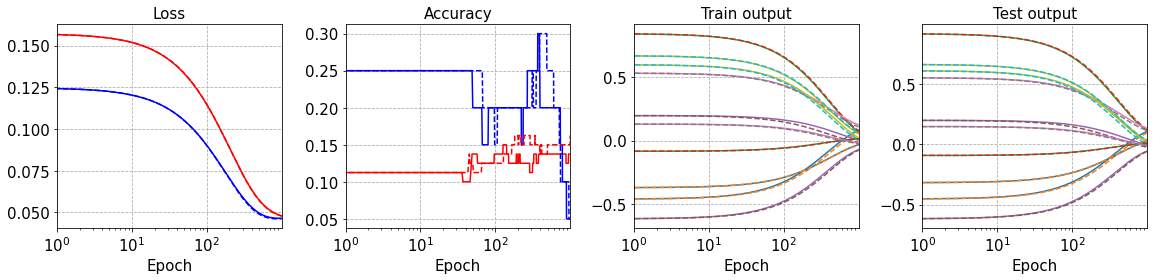

In [10]:
visualize(cfg, results, ntk_results, ar_y_tr, ar_y_te, 0)